In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [1]:
import tensorflow_hub as hub

In [3]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [4]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [5]:
# Prepare data dirs
train_dir = '/home/erick/Desktop/mcc20201/deepl/dlgit/datasets/PetImages/train/'
val_dir = '/home/erick/Desktop/mcc20201/deepl/dlgit/datasets/PetImages/val/'
train_cats_dir = '/home/erick/Desktop/mcc20201/deepl/dlgit/datasets/PetImages/train/trainCats'
train_dogs_dir = '/home/erick/Desktop/mcc20201/deepl/dlgit/datasets/PetImages/train/trainDogs'
validation_cats_dir = '/home/erick/Desktop/mcc20201/deepl/dlgit/datasets/PetImages/val/validationCats/'
validation_dogs_dir = '/home/erick/Desktop/mcc20201/deepl/dlgit/datasets/PetImages/val/validationDogs/'

In [6]:
# Number of training examples
num_cats = len(os.listdir(train_cats_dir))
num_dogs = len(os.listdir(train_dogs_dir))
# Number of validation examples
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
print(num_cats, num_dogs)
print(num_cats_val, num_dogs_val)

1000 1000
500 500


In [7]:
# Global settings to process the images
BATCH_SIZE = 50  # images will be handled in batches of 100
IMG_SIZE  = 224  # each image will be cropped to 150x150 pixels

# Pull images with keras.preprocessing
train_image_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                                horizontal_flip=True,
                                                                rotation_range=45,
                                                                zoom_range=0.5,
                                                                shear_range=0.2) 
validation_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

train_data = train_image_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=train_dir, shuffle=True,
                                                           target_size=(IMG_SIZE,IMG_SIZE), class_mode='binary')
val_data = validation_image_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=val_dir, shuffle=True,
                                                              target_size=(IMG_SIZE,IMG_SIZE), class_mode='binary')
sample, label= next(train_data) 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


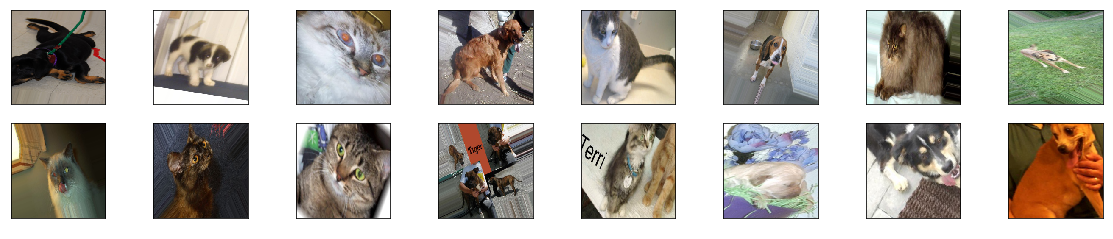

In [8]:
classes = ['cat','dog']
# Print example and its predicted class
plt.figure(figsize=(20,8))
i = 0
for image in sample:
    plt.subplot(4,8,i+1)
    plt.imshow(image)
    plt.xlabel(classes[int(label[i])], color='white')
    plt.xticks([])
    plt.yticks([])
    i += 1
    if 15 < i: break
plt.show()

(1, 1001)
[[ 0.26957998 -0.15140451 -0.21184705 ... -1.4169688   0.13211977
  -1.5855507 ]]


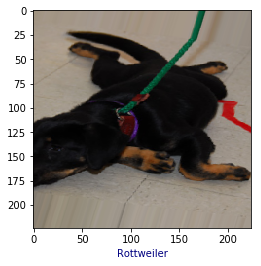

In [9]:
for image  in sample:
    result = model.predict(image[np.newaxis,...])
    print(result.shape)
    plt.imshow(image)
    print(result)
    plt.xlabel(imagenet_labels[np.argmax(result)], color='navy')
    break

In [10]:
# New model by transfer knowledge
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))


In [11]:
feature_batch = feature_extractor(sample)
print(feature_batch.shape)
feature_extractor.trainable = False

(50, 1280)


In [12]:
# Attach a classification layer to the feature extractor of MobileNET
model_t = tf.keras.models.Sequential([
    feature_extractor,
    #tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])
# 
model_t.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
# Training
history = model_t.fit_generator(train_data,
                    epochs=6,
                    validation_data=val_data)

Epoch 1/6
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


24/40 [=================>............] - ETA: 1:00 - loss: 0.3318 - accuracy: 0.8575

/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1

39/40 [============================>.] - ETA: 3s - loss: 0.2650 - accuracy: 0.8867

/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/env1/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/home/erick/anaconda3/envs/en

40/40 [==============================] - 203s 5s/step - loss: 0.2622 - accuracy: 0.8880 - val_loss: 0.0710 - val_accuracy: 0.9770
Epoch 2/6
40/40 [==============================] - 211s 5s/step - loss: 0.1334 - accuracy: 0.9450 - val_loss: 0.0604 - val_accuracy: 0.9780
Epoch 3/6
40/40 [==============================] - 212s 5s/step - loss: 0.1056 - accuracy: 0.9625 - val_loss: 0.0510 - val_accuracy: 0.9830
Epoch 4/6
40/40 [==============================] - 211s 5s/step - loss: 0.1048 - accuracy: 0.9585 - val_loss: 0.0527 - val_accuracy: 0.9760
Epoch 5/6
40/40 [==============================] - 192s 5s/step - loss: 0.0944 - accuracy: 0.9670 - val_loss: 0.0474 - val_accuracy: 0.9840
Epoch 6/6
40/40 [==============================] - 207s 5s/step - loss: 0.0938 - accuracy: 0.9595 - val_loss: 0.0499 - val_accuracy: 0.9830


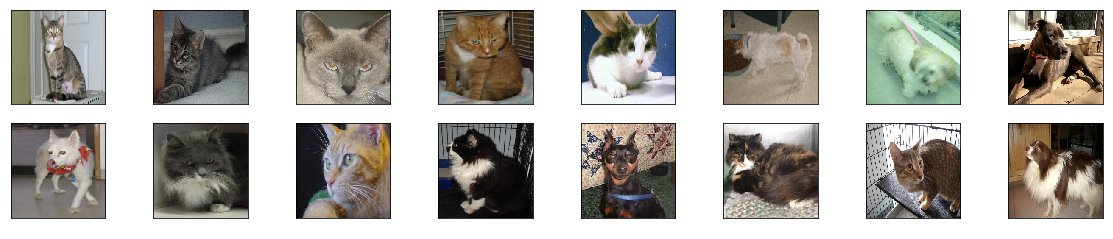

In [14]:
val_sample, _= next(val_data) 
# Print example and its predicted class
plt.figure(figsize=(20,8))
i = 0
for image in val_sample:
    plt.subplot(4,8,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[model_t.predict([[image]]).argmax()], color='white')
    i += 1
    if 15 < i: break
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

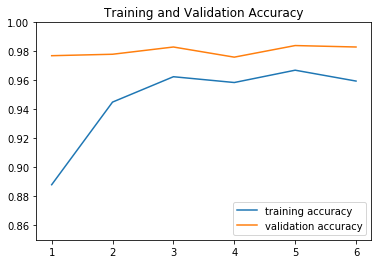

In [20]:
plt.plot(range(1,7), history.history['accuracy'], label='training accuracy')
plt.plot(range(1,7), history.history['val_accuracy'], label='validation accuracy')
plt.ylim(0.85,1.0)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')